In [3]:
%matplotlib inline

In [4]:
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
from matplotlib.mlab import PCA
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
import seaborn as sns
from sklearn import manifold
from collections import defaultdict
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import linregress
from __future__ import division
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
import matplotlib.gridspec as gridspec

/Users/nranu/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
np.random.seed(0)

GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")
def Read10x(filepath):   
    with tables.open_file(filepath, 'r') as f:
        try:
            group = f.get_node(f.root)
        except tables.NoSuchNodeError:
            print "That genome does not exist in this file."
        gene_ids = getattr(group, 'gene_ids').read()
        gene_names = getattr(group, 'gene_names').read()
        gene = getattr(group, 'gene').read()
        umi_corrected_reads=getattr(group, 'umi_corrected_reads').read()
        nonconf_mapped_reads=getattr(group, 'nonconf_mapped_reads').read()
        conf_mapped_uniq_read_pos=getattr(group, 'conf_mapped_uniq_read_pos').read()
        unmapped_reads=getattr(group, 'unmapped_reads').read()
        barcodes = getattr(group, 'barcode').read()
        reads = getattr(group, 'reads').read()
        umi = getattr(group, 'umi').read()

        TABLE=pd.DataFrame()
        TABLE['bc']=barcodes
        TABLE['umi']=umi
        #TABLE['bcumi']=zip(barcodes,umi)
        TABLE['gene']=gene
        TABLE['unique']=[1]*len(TABLE)
        TABLE['map_logical']=conf_mapped_uniq_read_pos>0
        TABLE['read_counts']=reads+nonconf_mapped_reads+unmapped_reads
        return TABLE

def get_gene(BC,df_1):
    Total=df_1.gene[df_1.bc==BC].value_counts().to_frame()
    Total.columns=['Counts']
    genes1=np.zeros(32739)
    for index,rows in Total.iterrows():
        genes1[index]=rows['Counts']
    return genes1[:-1]
def setenv(newDict):
    DNA={}
    DNA['A']='00'
    DNA['C']='01'
    DNA['G']='10'
    DNA['T']='11'

    BC_DNA2={}
    for i in newDict.iterkeys(): 
        string=newDict[i]
        for j in DNA.iterkeys():
            string=string.replace(j,DNA[j])
        BC_DNA2[i]=int(string,2)
    return BC_DNA2
def hamming_distance(s1, s2):
    #Return the Hamming distance between equal-length sequences
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))



In [32]:
newDict = {}
#insert path to barcode text file
with open('/../enriched_barcodes.txt', 'r') as f:
    for line in f:
        splitLine = line.split(',')
        newDict[int(splitLine[0])] = splitLine[1][:-1]
BC=setenv(newDict)

In [33]:
#CD_19, insert gene expression profile path
#filtered_matrix_h5='/.../filtered_gene_bc_matrices_h5.h5'

#HLA_DR, insert gene expression profile path
filtered_matrix_h5='/../filtered_gene_bc_matrices_h5.h5'

genome = "hg19"

#load expression profile
%time gene_bc_matrix = get_matrix_from_h5(filtered_matrix_h5, genome)

CPU times: user 107 ms, sys: 38.4 ms, total: 145 ms
Wall time: 154 ms


In [34]:
gnames=gene_bc_matrix.gene_names
cnames=gene_bc_matrix.barcodes
DGE=pd.DataFrame(gene_bc_matrix.matrix.toarray())
DGE.index=gnames
DGE.columns=cnames
cumi=DGE.sum()

In [16]:
#HLA_DR
list_f2=[4,5,6,7,8,9,12,13,14,15,16,17,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,55,56,58,59,60,61,62,63,64,65,68]

#CD_19
list_g2=[1,2,3,4,5,6,8,15,16,17,18,19,20,21,22,23,24,27,28]

#AS_DC
list_c=[34,35,37,38,39,40,41,42,43]

In [47]:
#Chose which list contains the desired barcodes
des=defaultdict(int)
for item in list_f2:
    des[item]=str(item)+'_'+str(BC[item])+'_3'

In [48]:
#load gene expression profile 
enrich=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/Gene_expression/HLA_DR_Gene_expression_matrix.h5',key='10X')

In [49]:
en=enrich[des.values()]
en.index=gnames

In [51]:
DGE=pd.DataFrame(gene_bc_matrix.matrix.toarray())
DGE.index=gnames
DGE.columns=cnames
DGE=pd.concat([DGE.T,en.T])
DGE=DGE.T

In [52]:
#PCA
cumi=DGE.sum()
DGE_0=(DGE>0).copy()
gmedian=DGE.sum().median()
#normalize data to UMI median 
DGE_tpmedian=(gmedian * (DGE / cumi))
#log2 transform
DGE_ltpm=np.log2(DGE_tpmedian+1)

#Chose genes that are expressed in greater than 3 cells
DGE_ltpm0=DGE_ltpm[((DGE>0).sum(axis=1)>3)]

#Lowess regression on the mean expression vs the standard deviation of each gene
gmeans=DGE_ltpm0.mean(axis=1)
gstd=DGE_ltpm0.std(axis=1)

w=pd.DataFrame(lowess(gstd, gmeans, frac=.33))
w.index=gstd.index

#Threshold on variation to get ~1000 variable genes
DGE_ltpmvar=DGE_ltpm0[gstd>w[1]+.4]

#Z score the data
DGEZ=pd.DataFrame(sklearn.preprocessing.scale(DGE_ltpmvar,axis=1))
DGEZ.index=DGE_ltpmvar.index
DGEZ.columns=DGE.columns
pca=sklearn.decomposition.PCA(n_components=20)
    
#PCA
pca.fit(DGEZ[cnames])
U=pd.DataFrame(pca.fit_transform(DGEZ[cnames]))
S=pca.explained_variance_
V=pd.DataFrame(pca.components_).T
V.index=DGE[cnames].columns
U.index=DGEZ.index

In [54]:
DGE_t=DGEZ[cnames].copy().T
V_train=pd.DataFrame()
for i in range(np.shape(U)[1]):
    V_train[i]=DGE_t.dot(U[i])

In [55]:
#project enriched data on to the PCs defined above
DGE_t=DGEZ[des.values()].T
V_test=pd.DataFrame()
for i in range(np.shape(U)[1]):
    V_test[i]=DGE_t.dot(U[i])

In [56]:
V_test['bc']=[newDict[int(x.split('_')[0])] for x in V_test.index]
V_train['bc']=[x.split('-')[0] for x in V_train.index]

In [35]:
Final=pd.concat([V_train,V_test])

In [36]:
#Save data
#V_test.to_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/PCA/HLA_DR_test.h5',key='10X')

In [37]:
#Find the euclidean distance shift of cells pre and post enrichment in the top 5 PCs
vdist=pd.DataFrame(sklearn.metrics.pairwise.euclidean_distances(Final[range(6)]))
vdist.columns=Final.index
vdist.index=Final.index
hist=vdist.values.flatten()

In [38]:
#make a dataframe of cell barcode, distance shifted, and UMI count
dist_u=defaultdict(int)
cumi=DGE.sum()
for BC_ in list_f2:
    barcode=newDict[BC_]
    barcode2=BC[BC_]
    dist_u[str(BC_)+'_'+barcode]=[vdist.loc[barcode+'-1'][str(BC_)+'_'+str(barcode2)+'_3'], cumi.loc[barcode+'-1']]
d=pd.DataFrame.from_dict(dist_u,orient='index')
d.columns=['distance','Umi']

Text(0.5,1,u'$\\mathdefault{HLA-DR^{+} cells}$')

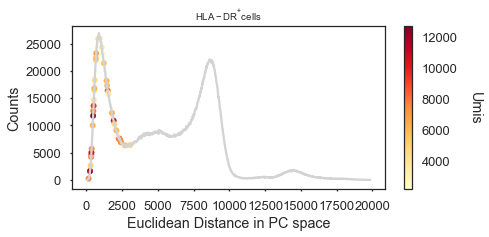

In [39]:
#plotting code
sns.set(style='white')
sns.set_context("talk")

fig,ax=plt.subplots(figsize=(7,3))
y,binEdges=np.histogram(hist[hist>0],bins=1000)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-',c='#D3D3D3')

normalize = mcolors.Normalize(vmin=d['Umi'].min(), vmax=d['Umi'].max())
colormap = cm.YlOrRd
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(d['Umi'])


d_counts=np.interp(d.distance.values,bincenters,y)
fu=[scalarmappaple.to_rgba(x) for x in d.Umi]
plt.scatter(d.distance.values,d_counts,s=30,c=fu,cmap='YlOrRd')
#plt.ylim([0,35000])

# Drawing the side color bar



for n in d['Umi']:
    plt.plot(color=colormap(normalize(n)))

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(d['Umi'])
cbar=plt.colorbar(scalarmappaple)
plt.xlabel('Euclidean Distance in PC space')
plt.ylabel('Counts')
#plt.xscale('log')
cbar.ax.set_ylabel('Umis', rotation=270,labelpad=25)
ax.tick_params(axis=u'both', which=u'both',length=2)
plt.minorticks_off()
sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 10,'text.fontsize': 10,'legend.fontsize': 10,
   'xtick.labelsize': 10,'ytick.labelsize': 10,'text.usetex': False})

plt.title('$\mathdefault{HLA-DR^{+} cells}$')

In [416]:
#TSNE
pca.fit(DGEZ)
U2=pd.DataFrame(pca.fit_transform(DGEZ))
S2=pca.explained_variance_
V2=pd.DataFrame(pca.components_).T
V2.index=DGE.columns
U2.index=DGEZ.index

In [417]:
#TSNE with top 6 components
model=sklearn.manifold.TSNE(n_components=2,perplexity=10,init='pca')
T_sne=pd.DataFrame(model.fit_transform(V2[range(6)]))
T_sne.columns=['T1','T2']
T_sne.index=V2.index

In [418]:
#Save data
#T_sne.to_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/TSNE/YY.h5',key='10X')

In [20]:
#load library specific Data
V_train=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/PCA/CD_19_train.h5',key='10X')
V_test=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/PCA/CD_19_test.h5',key='10X')

In [9]:
#load library specific Data
T_sne=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/TSNE/HLA_DR.h5',key='10X')

/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:160: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


(-110, 110)

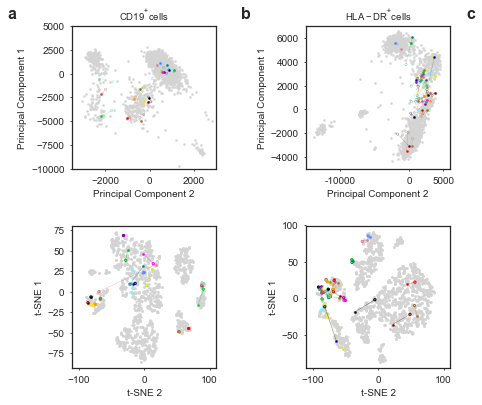

In [31]:
#plotting code
fig,ax=plt.subplots(figsize=(10,5))#2.5,2.5


sns.set(style='white')
sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 10,'text.fontsize': 10,'legend.fontsize': 10,
   'xtick.labelsize': 10,'ytick.labelsize': 10,'text.usetex': False})
colors=['#000000','#800000','#FF0000','#AA6E28','#FF9900','#808000','#FFEA00','#BEFF00','#00BE00','#008080','#64FFFF','#000080','#4385FF','#820096','#FF00FF',"#e07b91", "#d33f6a", "#11c638", "#8dd593", "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0","#483d8b","#ffa500","#ba55d3",'#000000','#800000','#FF0000','#AA6E28','#FF9900','#808000','#FFEA00','#BEFF00','#00BE00','#008080','#64FFFF','#000080','#4385FF','#820096','#FF00FF',"#e07b91", "#d33f6a", "#11c638", "#8dd593", "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0","#483d8b","#ffa500","#ba55d3"]
#######################################################################################################################


V_train=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/PCA/CD_19_train.h5',key='10X')
V_test=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/PCA/CD_19_test.h5',key='10X')

newDict = {}
with open('/Volumes/broad_blainey_lab_storage/Nav/temp/SC_enrichment/CD_19_barcodes.txt', 'r') as f:
    for line in f:
        splitLine = line.split(',')
        newDict[int(splitLine[0])] = splitLine[1][:-1]
BC=setenv(newDict)

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.05, right=0.25,top=.95,bottom=0, wspace=0.25,hspace=0.4)
ax1 = plt.subplot(gs1[0, :])
#ax1.text(-.3,1,'A',fontsize=15,weight="bold")
temp=V_train
temp1_=V_test
temp1_['filter']=[int(x.split('_')[2]) for x in temp1_.index]
temp1_['filter']=[int(x.split('_')[2]) for x in temp1_.index]
temp1=temp1_[temp1_['filter']==3]

var=[1]
col='#D3D3D3'
bc=temp1.bc.values
s1=5
s2=5

for i in range(0,len(var)):
    g=0 
    plt.scatter(temp[var[i]],temp[0],c=col,s=s1)
    for z in list_g2:
        string1=newDict[z]
        x1=temp.loc[string1+'-1'][var[i]]
        x2=temp1[var[i]][temp1.bc==string1]
        y1=temp.loc[string1+'-1'][0]
        y2=temp1[0][temp1.bc==string1]
        plt.scatter(x1,y1,c=colors[g],s=s2)
        plt.scatter(x2,y2,facecolors='none', edgecolors=colors[g],linewidth=.25,s=s2)
        plt.plot([x1,x2],[y1,y2],colors[g],ls='dashed',dashes=[.5, .5, .5, .5],lw=.25)
        g+=1
        plt.ylabel('Principal Component 1',fontsize=10)
        plt.xlabel('Principal Component 2',fontsize=10)

ax1.tick_params(axis=u'both', which=u'both',length=2)
ax1.annotate('a', size=16,weight="bold", xy=(-65, 150),xycoords='axes points')
plt.ylim([-10000,5000])
plt.xlim([-3500,3000])
plt.title('$\mathdefault{CD19^{+} cells}$')

#######################################################################################################################

ax2 = plt.subplot(gs1[-1, :])

T_sne=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/TSNE/CD_19.h5',key='10X')

temp=T_sne.loc[V_train.index]
temp1_=T_sne.loc[V_test.index]
temp1_['bc']=[newDict[int(x.split('_')[0])] for x in temp1_.index]
temp1_['filter']=[int(x.split('_')[2]) for x in temp1_.index]
temp1_['filter']=[int(x.split('_')[2]) for x in temp1_.index]
temp1=temp1_[temp1_['filter']==3]
var=[1]
bc=temp1.bc.values
s1=5
s2=5

for i in range(0,len(var)):
    g=0
    plt.scatter(temp['T1'],temp['T2'],c=col,s=s1)    
    for z in list_g2:
        string1=newDict[z]
        x1=temp.loc[string1+'-1']['T1']
        x2=temp1['T1'][temp1.bc==string1]
        y1=temp.loc[string1+'-1']['T2']
        y2=temp1['T2'][temp1.bc==string1]
        plt.scatter(x1,y1,c=colors[g],s=s2)
        plt.scatter(x2,y2,facecolors='none', edgecolors=colors[g],linewidth=1,s=s2)
        plt.plot([x1,x2],[y1,y2],colors[g],ls='dashed',dashes=[.5, .5, .5, .5],lw=.5)
        g+=1
plt.ylabel('t-SNE 1',fontsize=10)
plt.xlabel('t-SNE 2',fontsize=10)

ax2.tick_params(axis=u'both', which=u'both',length=2)
plt.minorticks_off()
#plt.ylim([-11000,4000])
plt.xlim([-110,110])


#######################################################################################################################

gs2 = gridspec.GridSpec(2, 2)
gs2.update(left=0.375, right=0.575, top=.95,bottom=0,wspace=0.25,hspace=0.4)


ax3 = plt.subplot(gs2[0, :])
V_train=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/PCA/HLA_DR_train.h5',key='10X')
V_test=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/PCA/HLA_DR_test.h5',key='10X')

newDict = {}
with open('/Volumes/broad_blainey_lab_storage/Nav/temp/SC_enrichment/enriched_barcodes.txt', 'r') as f:
    for line in f:
        splitLine = line.split(',')
        newDict[int(splitLine[0])] = splitLine[1][:-1]
BC=setenv(newDict)

#ax1.text(-.3,1,'A',fontsize=15,weight="bold")
temp=V_train
temp1_=V_test
temp1_['filter']=[int(x.split('_')[2]) for x in temp1_.index]
temp1_['filter']=[int(x.split('_')[2]) for x in temp1_.index]
temp1=temp1_[temp1_['filter']==3]

col='#D3D3D3'
col2='r'
col3='b'
bc=temp1.bc.values
s1=5
s2=5

for i in range(0,len(var)):
    g=0 
    plt.scatter(temp[var[i]],temp[0],c=col,s=s1)
    for z in list_f2:
        string1=newDict[z]
        x1=temp.loc[string1+'-1'][var[i]]
        x2=temp1[var[i]][temp1.bc==string1]
        y1=temp.loc[string1+'-1'][0]
        y2=temp1[0][temp1.bc==string1]
        plt.scatter(x1,y1,c=colors[g],s=s2)
        plt.scatter(x2,y2,facecolors='none', edgecolors=colors[g],linewidth=.25,s=s2)
        plt.plot([x1,x2],[y1,y2],colors[g],ls='dashed',dashes=[.5, .5, .5, .5],lw=.25)
        g+=1
        plt.ylabel('Principal Component 1',fontsize=10)
        plt.xlabel('Principal Component 2',fontsize=10)

ax3.tick_params(axis=u'both', which=u'both',length=2)
ax3.annotate('b', size=16,weight="bold", xy=(-65, 150),xycoords='axes points')
ax3.annotate('c', size=16,weight="bold", xy=(160, 150),xycoords='axes points')
plt.ylim([-5000,7000])
plt.xlim([-15000,6000])
plt.xticks([-10000,0,5000],[-10000,0,5000])
plt.title('$\mathdefault{HLA-DR^{+} cells}$')

#######################################################################################################################

ax4 = plt.subplot(gs2[-1, :])
T_sne=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/TSNE/HLA_DR.h5',key='10X')

temp=T_sne.loc[V_train.index]
temp1_=T_sne.loc[V_test.index]
temp1_['bc']=[newDict[int(x.split('_')[0])] for x in temp1_.index]
temp1_['filter']=[int(x.split('_')[2]) for x in temp1_.index]
temp1_['filter']=[int(x.split('_')[2]) for x in temp1_.index]
temp1=temp1_[temp1_['filter']==3]

bc=temp1.bc.values
s1=5
s2=5

for i in range(0,len(var)):
    g=0
    plt.scatter(temp['T1'],temp['T2'],c=col,s=s1) 
    for z in list_f2:
        string1=newDict[z]
        x1=temp.loc[string1+'-1']['T1']
        x2=temp1['T1'][temp1.bc==string1]
        y1=temp.loc[string1+'-1']['T2']
        y2=temp1['T2'][temp1.bc==string1]
        plt.scatter(x1,y1,c=colors[g],s=s2)
        plt.scatter(x2,y2,facecolors='none', edgecolors=colors[g],linewidth=1,s=s2)
        plt.plot([x1,x2],[y1,y2],colors[g],ls='dashed',dashes=[.5, .5, .5, .5],lw=.5)
        g+=1
plt.ylabel('t-SNE 1',fontsize=10)
plt.xlabel('t-SNE 2',fontsize=10)

ax4.tick_params(axis=u'both', which=u'both',length=2)
plt.minorticks_off()
#plt.ylim([-11000,4000])
plt.xlim([-110,110])